In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
import seaborn as sns
from visualize_foreground import *

R_sun = 6.957e10

In [6]:
sns.set_style("whitegrid")  # Use "white", "dark", "whitegrid", "darkgrid" or "ticks"
sns.set_context("talk")     # Use "paper", "talk", "poster" for different sizes

In [3]:
def read_solar_S_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        r_over_R = np.array(f['/r_over_R'])
        c_s = np.array(f['/c_s'])
        Gamma_1 = np.array(f['/Gamma_1'])
        T0 = np.array(f['/T'])
        rho0 = np.array(f['/rho'])
        p0 = np.array(f['/p'])
        
        r_over_R = np.flip(r_over_R)
        c_s = np.flip(c_s)
        Gamma_1 = np.flip(Gamma_1)
        T0 = np.flip(T0)
        rho0 = np.flip(rho0)
        p0 = np.flip(p0)

        variables = {'r_over_R': r_over_R, 'c_s': c_s, 'Gamma_1': Gamma_1, 'T0': T0, 'rho0': rho0, 'p0': p0}
    return variables

In [29]:
solar_S = read_solar_S_hdf5("../additional_files/solar_s.h5")
variables_0, info = read_bg("../data/mpi_test/background_0.h5")
variables_1, info = read_bg("../data/mpi_test/background_1.h5")
variables_2, info = read_bg("../data/mpi_test/background_2.h5")
variables_3, info = read_bg("../data/mpi_test/background_3.h5")

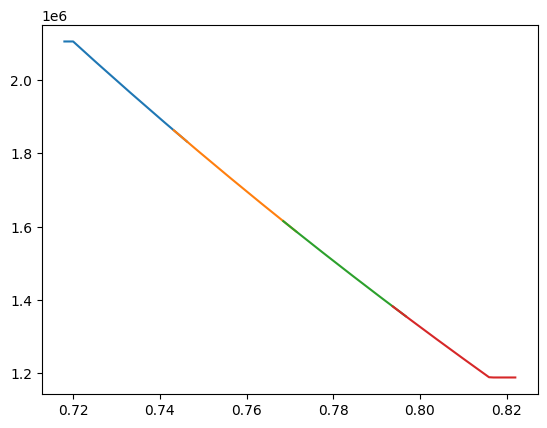

In [30]:
plt.plot(variables_0['r']/R_sun, variables_0['T0'])
plt.plot(variables_1['r']/R_sun, variables_1['T0'])
plt.plot(variables_2['r']/R_sun, variables_2['T0'])
plt.plot(variables_3['r']/R_sun, variables_3['T0'])

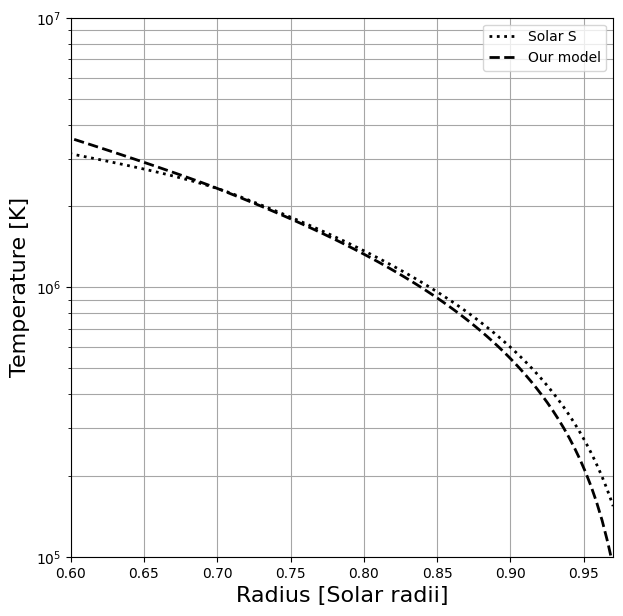

In [79]:
# Format colorbar ticks in scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)

fig, ax = plt.subplots(figsize=(7, 7))
formatter.set_powerlimits((-3, 4))  # you can adjust these limits if needed


ax.semilogy(solar_S['r_over_R'], solar_S['T0'], color="black", linestyle=":", linewidth=2, label="Solar S")
ax.semilogy(variables['r']/R_sun, variables['T0'], color="black", linestyle="--", linewidth=2, label="Our model")
ax.set_xlim(0.6, 0.97)
ax.set_ylim(1e5, 1e7)
#ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("Radius [Solar radii]", fontsize=16)
ax.set_ylabel("Temperature [K]", fontsize=16)
ax.legend()

#set grid on plot
ax.grid(True, which="both", ls="-", color='0.65')

#fig.tight_layout()
plt.savefig("../thesis/mastermal-ita/solar_vs_model_plots/Temperature.pdf")
plt.show()


In [111]:
t = np.zeros(100)
for i in range(100):
    variables, info = read_fg("../data/rk2_upw2_pertubation_no_max/snap%d.h5"%(i))
    t[i] = info['t']


np.diff(t)

array([100001.        ,  10008.4317007 ,  10007.55048041,  10002.27279552,
        10019.57554554,  10021.6831196 ,  10018.27639238,  10017.56481113,
        10022.9729229 ,  10020.55819904,  10049.63012559,  10025.70831611,
        10036.87074999,  10048.50649042,  10008.88630122,  10014.13821617,
        10056.43897652,  10055.52244216,  10021.71753266,  10022.09781427,
        10038.56169638,  10024.1276881 ,  10010.15267766,  10000.93866622,
        10038.48280529,  10072.80689099,  10003.62708998,  10014.01299244,
        10076.18450736,  10070.54117792,  10037.42531018,  10000.76613814,
        10000.16760399,  10081.5723712 ,  10045.15140613,  10064.76400024,
        10075.68789957,  10001.5602515 ,  10059.72377145,  10022.21199593,
        10042.8690655 ,  10072.88416516,  10005.42567048,  10016.51125953,
        10060.15049412,  10081.65936934,  10020.21431859,  10014.33033663,
        10010.15200203,  10078.7625915 ,  10018.38605809,  10056.19494548,
        10036.34650489,  

In [114]:
n_He = 10**(10.93)
n_H = 10**(12)

X_He = 4*n_He/(n_H + 4*n_He)
X_He

0.2539847742765455

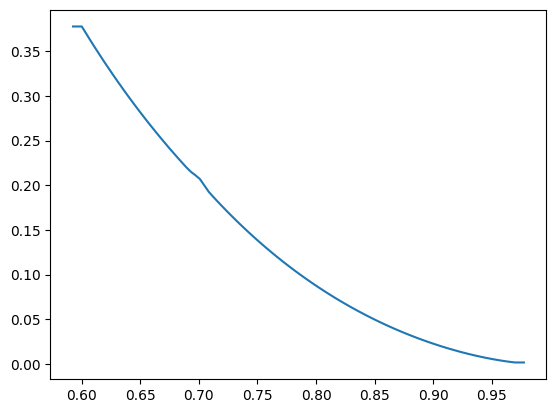

In [102]:
plt.plot(variables['r']/R_sun, variables['rho0'])

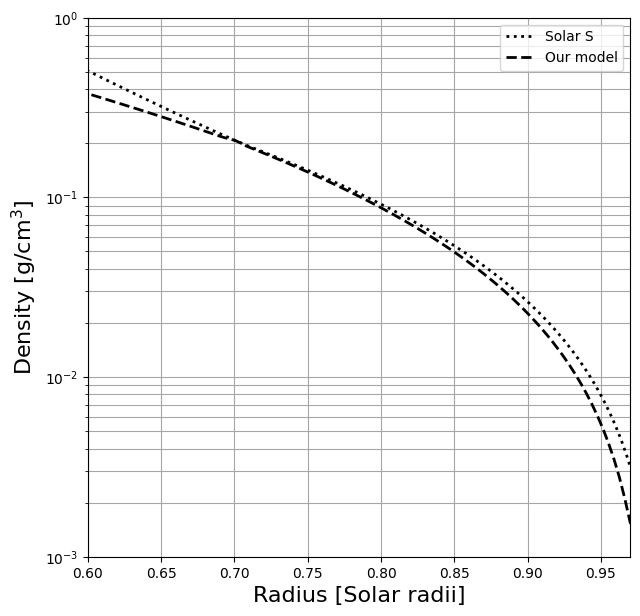

In [76]:
fig, ax = plt.subplots(figsize=(7, 7))
formatter.set_powerlimits((-1, 1))  # you can adjust these limits if needed

#set grid on plot
ax.grid(True, which="both", ls="-", color='0.65')

ax.semilogy(solar_S['r_over_R'], solar_S['rho0'], color="black", linestyle=":", linewidth=2, label="Solar S")
ax.semilogy(variables['r']/R_sun, variables['rho0'], color="black", linestyle="--", linewidth=2, label="Our model")
ax.set_xlim(0.6, 0.97)
ax.set_ylim(1e-3, 1e0)
#ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("Radius [Solar radii]", fontsize=16)
ax.set_ylabel("Density [g/cm$^3$]", fontsize=16)
ax.legend()
#fig.tight_layout()
plt.savefig("../thesis/mastermal-ita/solar_vs_model_plots/Density.pdf")
plt.show()

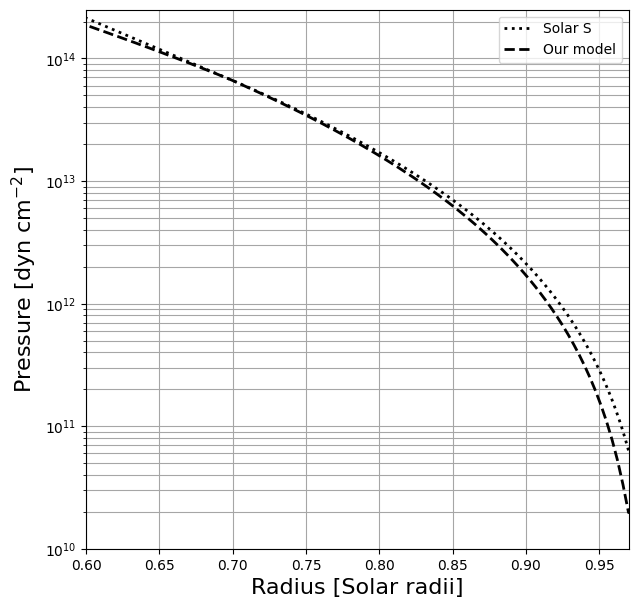

In [78]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.semilogy(solar_S['r_over_R'], solar_S['p0'], color="black", linestyle=":", linewidth=2, label="Solar S")
ax.semilogy(variables['r']/R_sun, variables['p0'], color="black", linestyle="--", linewidth=2, label="Our model")
ax.set_xlim(0.6, 0.97)
ax.set_ylim(1e10, 2.5e14)
#ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("Radius [Solar radii]", fontsize=16)
ax.set_ylabel("Pressure [dyn cm$^{-2}$]", fontsize=16)
ax.legend()

#set grid on plot
ax.grid(True, which="both", ls="-", color='0.65')

#fig.tight_layout()
plt.savefig("../thesis/mastermal-ita/solar_vs_model_plots/Pressure.pdf")
plt.show()

/var/folders/k6/k6jkpmqs13l4qhz_xy4wzlmw0000gn/T/ipykernel_2273/2873982370.py:6: RuntimeWarning: invalid value encountered in divide
  solar_S['g'] = -G*solar_S['M']/((solar_S['r_over_R']*R_sun)**2)


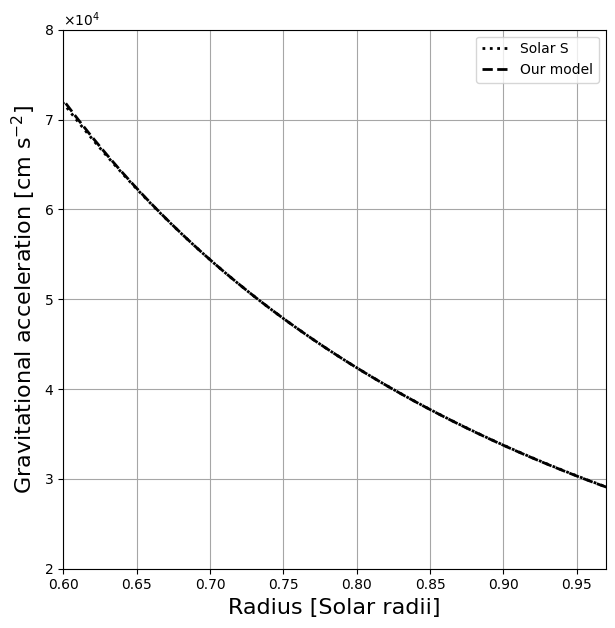

In [94]:
M_sun = 1.989e33 # g
G = 6.6743e-8 # cm^3 g^-1 s^-2

solar_S['M'] = 4*np.pi*R_sun**3 * cumtrapz(solar_S['rho0']*(solar_S['r_over_R'])**2, solar_S['r_over_R'], initial=0)

solar_S['g'] = -G*solar_S['M']/((solar_S['r_over_R']*R_sun)**2)

fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(solar_S['r_over_R'], np.abs(solar_S['g']), color="black", linestyle=":", linewidth=2, label="Solar S")
ax.plot(variables['r']/R_sun, np.abs(variables['g']), color="black", linestyle="--", linewidth=2, label="Our model")
ax.set_xlim(0.6, 0.97)
ax.set_ylim(0.2e5, 0.8e5)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("Radius [Solar radii]", fontsize=16)
ax.set_ylabel("Gravitational acceleration [cm s$^{-2}$]", fontsize=16)

#set grid on plot
ax.grid(True, which="both", ls="-", color='0.65')

ax.legend()

#fig.tight_layout()
plt.savefig("../thesis/mastermal-ita/solar_vs_model_plots/Gravitational_acceleration.pdf")
plt.show()

In [95]:
X = 0.75
Y = 0.23

1/(2*X + 3/4*Y)

0.5979073243647234

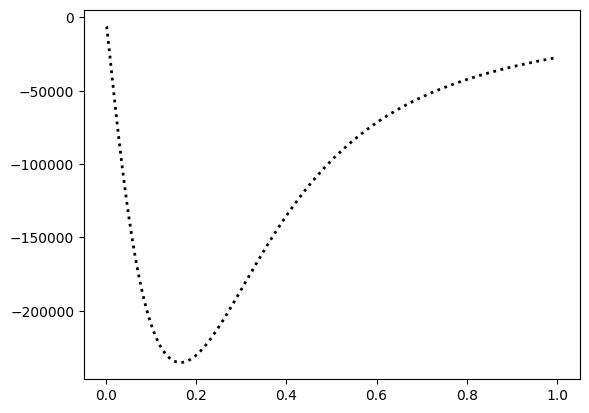

In [84]:
plt.plot(solar_S['r_over_R'], solar_S['g'], color="black", linestyle=":", linewidth=2, label="Solar S")

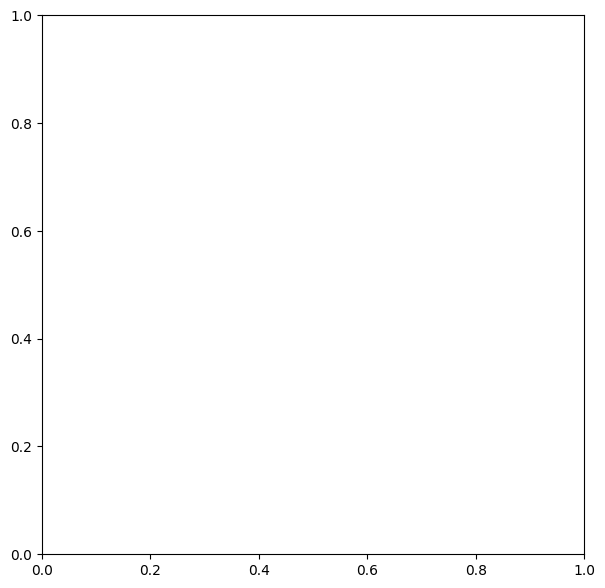

In [83]:
fig, ax = plt.subplots(figsize=(7, 7))



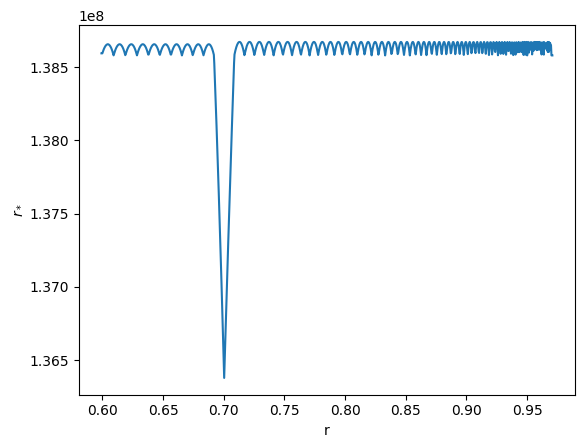

In [9]:
plt.plot(variables['r']/R_sun, variables['p0']/(variables['rho0']*variables['T0']))
plt.xlabel("r")
plt.ylabel("$r_*$")
plt.show()

In [126]:
R_sun * 0.15 / 10**6

10435.5

/var/folders/k6/k6jkpmqs13l4qhz_xy4wzlmw0000gn/T/ipykernel_2273/3146362200.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(bg_variables['r'][:-1]/R_sun, -bg_variables["p0"][:-1] *dz/dp0)


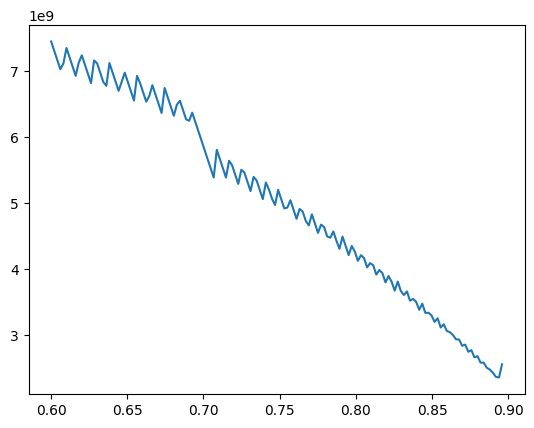

In [121]:
bg_variables, bg_info = read_bg("../data/rk2_upw2_pertubation_no_max/background.h5")

dz = np.diff(bg_variables['r'])
dp0 = np.diff(bg_variables['p0'])

plt.plot(bg_variables['r'][:-1]/R_sun, -bg_variables["p0"][:-1] *dz/dp0)


In [ ]:
!ls ../data/rk2_upw2_pertubation_no_max/background.h5.h5

In [29]:
L_z = (0.97-0.65)*R_sun
L_x = 0.05*R_sun

dx = 1e8
dz = 1e8

nx = int(L_x/dx)
nz = int(L_z/dz)
nx, nz

(34, 222)

Text(0, 0.5, 'Pressure scale height (cm)')

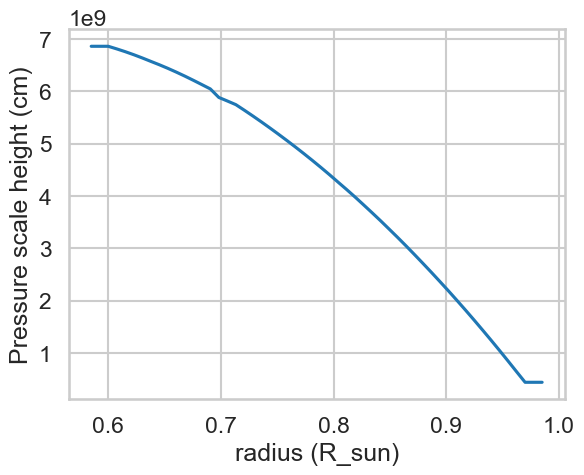

In [28]:
H = -p0_/(rho0_*g_)
plt.plot(r_/R_sun, H)
plt.xlabel("radius (R_sun)")
plt.ylabel("Pressure scale height (cm)")

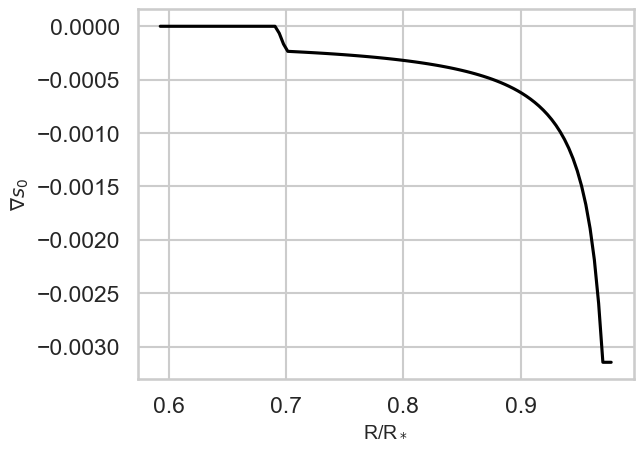

In [21]:
#plt.scatter(r_/R_sun, grad_s0_, color="black", s=10)
plt.plot(r_/R_sun, grad_s0_, color="black")
plt.xlabel("R/R$_*$", fontsize=14)
plt.ylabel(r"$\nabla s_0$", fontsize=14)
plt.show()

In [20]:
r_/R_sun

array([0.59293352, 0.59646676, 0.6       , 0.60362745, 0.6072549 ,
       0.61088235, 0.6145098 , 0.61813725, 0.62176471, 0.62539216,
       0.62901961, 0.63264706, 0.63627451, 0.63990196, 0.64352941,
       0.64715686, 0.65078431, 0.65441176, 0.65803922, 0.66166667,
       0.66529412, 0.66892157, 0.67254902, 0.67617647, 0.67980392,
       0.68343137, 0.68705882, 0.69068627, 0.69431373, 0.69794118,
       0.70156863, 0.70519608, 0.70882353, 0.71245098, 0.71607843,
       0.71970588, 0.72333333, 0.72696078, 0.73058824, 0.73421569,
       0.73784314, 0.74147059, 0.74509804, 0.74872549, 0.75235294,
       0.75598039, 0.75960784, 0.76323529, 0.76686275, 0.7704902 ,
       0.77411765, 0.7777451 , 0.78137255, 0.785     , 0.78862745,
       0.7922549 , 0.79588235, 0.7995098 , 0.80313725, 0.80676471,
       0.81039216, 0.81401961, 0.81764706, 0.82127451, 0.82490196,
       0.82852941, 0.83215686, 0.83578431, 0.83941176, 0.84303922,
       0.84666667, 0.85029412, 0.85392157, 0.85754902, 0.86117

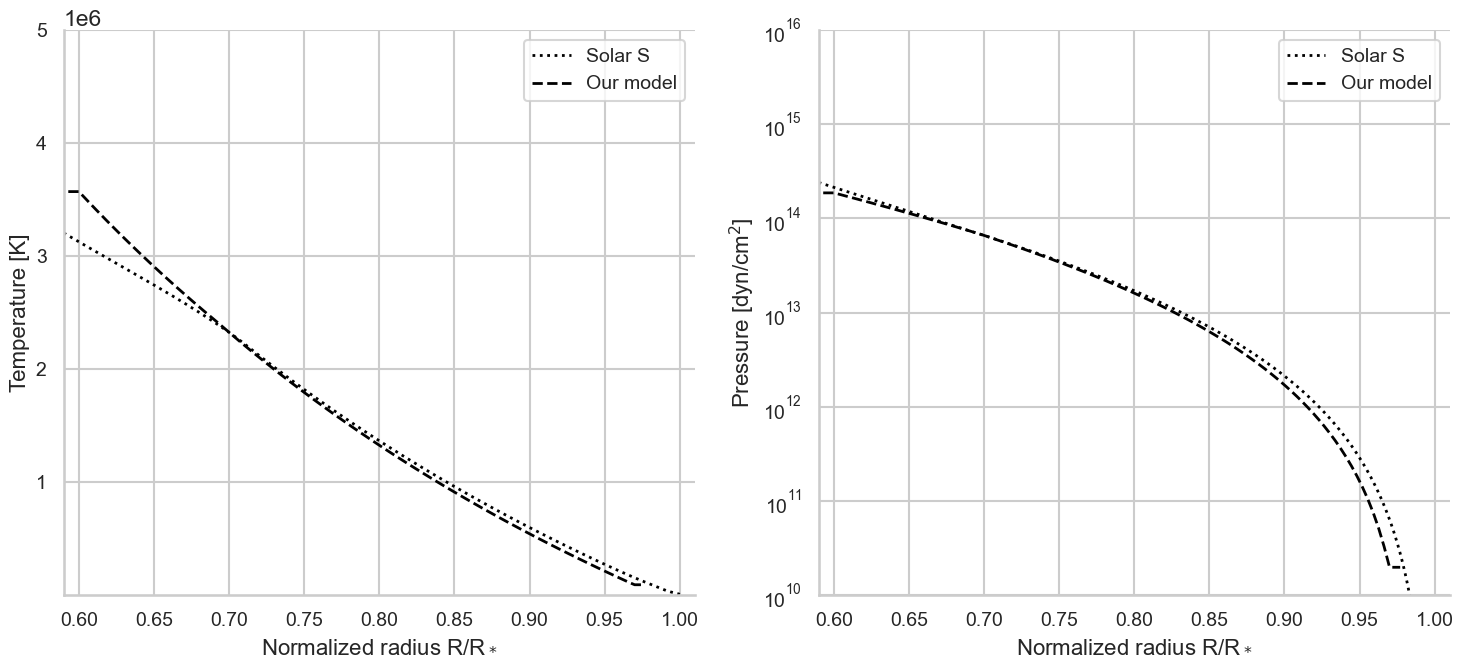

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 7))

ax[0].plot(r_over_R, T0, color="black", linestyle=":", linewidth=2, label="Solar S")
ax[0].plot(r_/R_sun, T0_, color="black", linestyle="--", linewidth=2, label="Our model")

ax[1].semilogy(r_over_R, p0, color="black", linestyle=":", linewidth=2, label="Solar S")
ax[1].semilogy(r_/R_sun, p0_, color="black", linestyle="--", linewidth=2, label="Our model")

for axis in ax:
    axis.tick_params(axis='both', labelsize=14)
    axis.set_xlabel("Normalized radius R/R$_*$", fontsize=16)
    axis.legend(fontsize=14)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)

ax[0].set_xlim(0.59, 1.01)
ax[0].set_ylim(1e3, 0.5e7)
ax[0].set_ylabel("Temperature [K]", fontsize=16)

ax[1].set_xlim(0.59, 1.01)
ax[1].set_ylim(1e10, 1e16)
ax[1].set_ylabel("Pressure [dyn/cm$^2$]", fontsize=16)

fig.tight_layout()
plt.show()


In [7]:
R_sun = 6.957e10
M_sun = 1.989e33
G = 6.6743e-8

M = 4*np.pi*R_sun**3 * cumtrapz(rho0*(r_over_R)**2, r_over_R, initial=0)
g = -G*M/((r_over_R*R_sun)**2)

/var/folders/k6/k6jkpmqs13l4qhz_xy4wzlmw0000gn/T/ipykernel_61115/103677430.py:6: RuntimeWarning: invalid value encountered in divide
  g = -G*M/((r_over_R*R_sun)**2)


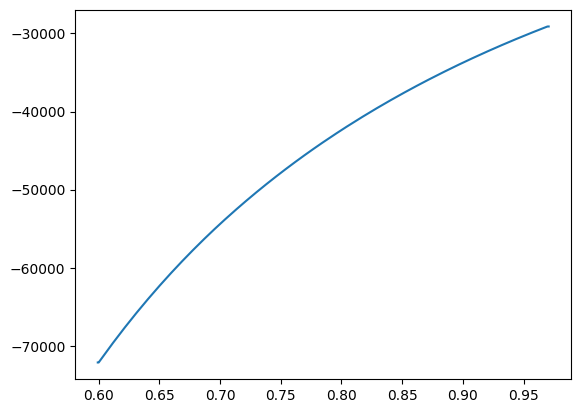

In [15]:
variables, info = read_bg('../data/vz_ten_copy/background.h5')


plt.plot(variables['r']/R_sun, variables['g'])
plt.show()

NameError: name 'r_over_R' is not defined

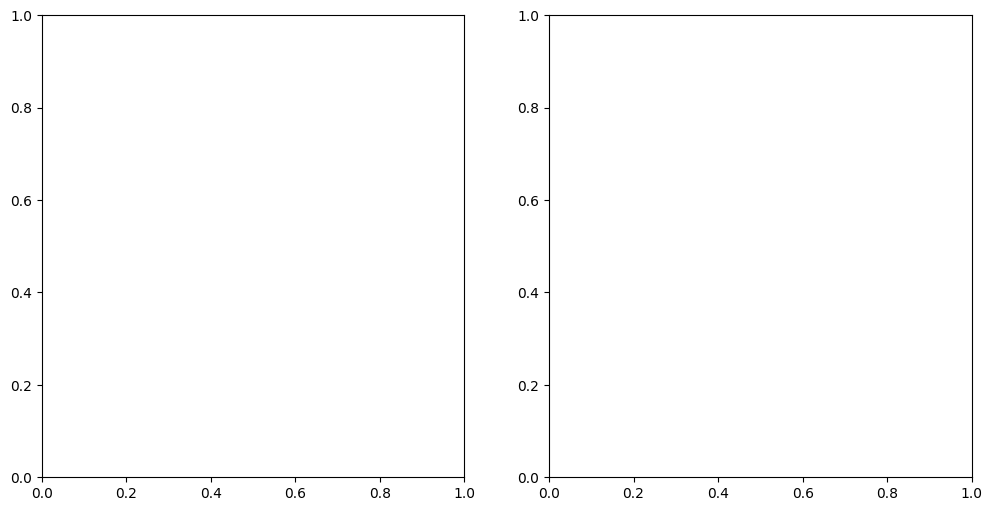

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

ax[0].semilogy(r_over_R, np.abs(g), color="black", linestyle=":", label="Solar S")
ax[0].semilogy(r_/R_sun, g_, color="black", linestyle="--", label="Our model")

ax[1].semilogy(r_over_R, rho0, color="black", linestyle=":", label="Solar S")
ax[1].semilogy(r_/R_sun, rho0_, color="black", linestyle="--", label="Our model")

ax[0].set_xlim(0.59,1.01)
ax[0].set_ylim(2e4,1e5)
ax[0].set_xlabel("Normalized radius R/R$_*$")
ax[0].set_ylabel("Gravitational acceleration [cm$^4$/(gs$^2$)]")
ax[0].legend()

ax[1].set_xlim(0.59,1.01)
ax[1].set_ylim(1e-3,0.1e1)
ax[1].set_xlabel("Normalized radius R/R$_*$")
ax[1].set_ylabel("Density [g/cm$^3$]")
ax[1].legend()

fig.tight_layout()
plt.show()

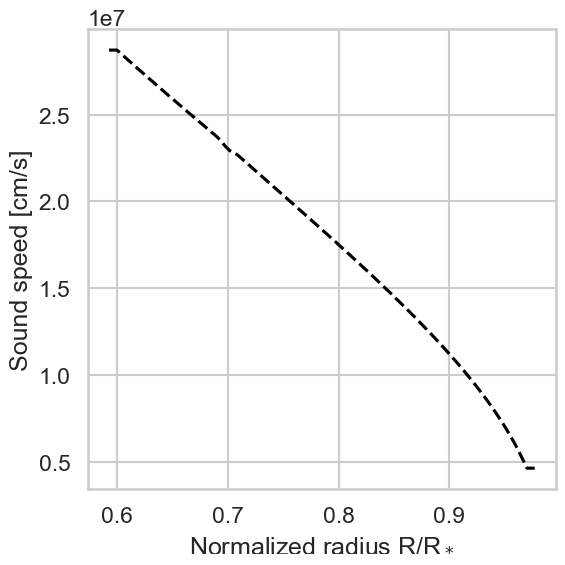

In [29]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(r_/R_sun, np.sqrt(5/3 * p0_/rho0_), color="black", linestyle="--")

#ax[0].set_ylim(2e4,1e5)
ax.set_xlabel("Normalized radius R/R$_*$")
ax.set_ylabel("Sound speed [cm/s]")


fig.tight_layout()
plt.show()

In [248]:
np.where(r_over_R>0.7)[0]

array([1046, 1047, 1048, ..., 2479, 2480, 2481])

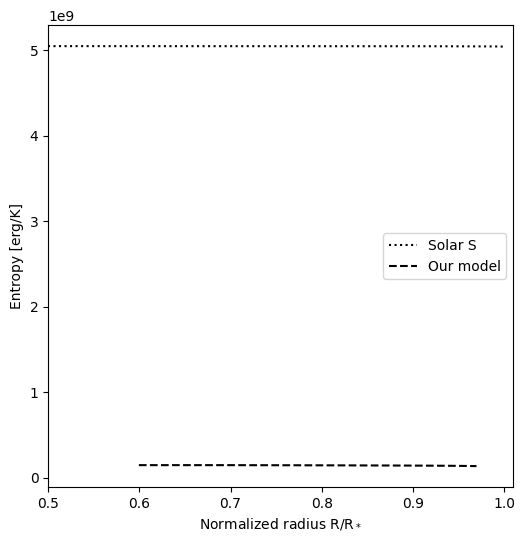

In [256]:
def k(r):
    # for now setting k as constant in radiative and convective zone
    if (r>=0.7*R_sun):
        return 0.001
    if r<0.7*R_sun:
        return 0

def get_nabla(r):
    nabla_ad = 0.4
    nabla_star = nabla_ad + k(r)
    return nabla_star, nabla_ad

gamma = 5/3

#Lantz after eq (10) 
r_star = P[0]/(rho0[0]*T0[0])
#Lantz after eq (72)
c_p = r_star/(1-1/Gamma_1[0])

s = np.zeros(len(T0))
s[0] = c_p*1e4

#entropy calculation
for i in range(0, len(T0)-1):
    dr = (r_over_R[i+1]-r_over_R[i])*R_sun
    
    H = - dr*p0[i+1]/(p0[i+1]-p0[i])
    #Lantz after eq (10) 
    r_star = p0[i+1]/(rho0[i+1]*T0[i+1])
    #Lantz after eq (72)
    c_p = r_star/(1-1/Gamma_1[i+1])
    nabla_star, nabla_ad = get_nabla(r_over_R[i+1]*R_sun)
    superad_param = nabla_star - nabla_ad
    
    ds_dr = - c_p/H * superad_param
    
    s[i+1] = s[i] + ds_dr * dr

fig, ax = plt.subplots(figsize=(6,6))

ax.plot(r_over_R, s, color="black", linestyle=":", label="Solar S")
ax.plot(r_/R_sun, s0_, color="black", linestyle="--", label="Our model")

ax.set_xlim(0.5,1.01)
ax.set_xlabel("Normalized radius R/R$_*$")
ax.set_ylabel("Entropy [erg/K]")
ax.legend()

plt.show()

In [130]:
n_H = 10**12
n_He = 10**(10.93)
X_H = n_H/(n_H+4*n_He)
X_He = 4*n_He/(n_H+4*n_He)
X_Z = 1 - X_H - X_He

1/(2*X_H + 3/4*X_He)

0.5943469172646373

In [158]:
x_size = 0.05*R_sun
z_size = (0.9-0.7)*R_sun

dx = 800000000
dz = 800000000

nx = int(x_size/dx)*2
nz = int(z_size/dz)*2
nx, nz

(8, 34)